In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [15]:
var_dict = {'geopotential': ('z', [200, 500, 850]), 'temperature': ('t', [200, 500, 850]), 'u_component_of_wind': ('u', [200, 500, 850]), 'v_component_of_wind': ('v', [200, 500, 850]), 'constants': ['lsm','orography','lat2d']}
output_vars = ['z_*', 't_*', 'u_*', 'v_*']
lead_time = 72
batch_size = 64
data_subsample = 2
norm_subsample = 30000

In [5]:
datadir = '/data/stephan/WeatherBench/5.625deg/'

In [6]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [12]:
ds_train = ds.sel(time=slice('1979', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [16]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample
)
dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)

DG start 18:32:12.564731
DG normalize 18:32:12.590290
DG load 18:32:35.030203
Loading data into RAM
DG done 18:41:56.659031
DG start 18:41:56.662950
DG normalize 18:41:56.694321
DG load 18:41:56.706673
Loading data into RAM
DG done 18:42:08.832442


In [31]:
X, y = dg_test[0]

In [32]:
X.shape, y.shape

((64, 32, 64, 15), (64, 32, 64, 12))

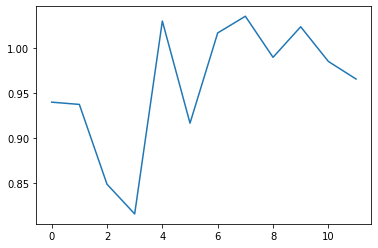

In [37]:
plt.plot(y.std(axis=(0, 1, 2)))

In [36]:
dg_test.data.level_names

<xarray.DataArray 'level_names' (level: 15)>
array(['z_200', 'z_500', 'z_850', 't_200', 't_500', 't_850', 'u_200',
       'u_500', 'u_850', 'v_200', 'v_500', 'v_850', 'lsm', 'orography',
       'lat2d'], dtype='<U9')
Coordinates:
  * level        (level) int64 200 500 850 200 500 850 200 ... 200 500 850 1 1 1
    level_names  (level) <U9 'z_200' 'z_500' 'z_850' ... 'orography' 'lat2d'

In [20]:
model = keras.models.load_model(
    '/home/rasp/data/myWeatherBench/predictions/saved_models/37-resnet_pred_all_lev.h5',
    custom_objects={'PeriodicConv2D': PeriodicConv2D}
)

In [22]:
preds = create_predictions(model, dg_test)

In [23]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, level: 3, lon: 64, time: 17448)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * level    (level) int64 200 500 850
Data variables:
    t        (time, lat, lon, level) float64 227.5 240.5 257.8 ... 230.0 249.0
    u        (time, lat, lon, level) float64 -0.2959 0.322 ... -0.997 2.119
    z        (time, lat, lon, level) float64 1.106e+05 5.09e+04 ... 1.18e+04
    v        (time, lat, lon, level) float64 -0.912 -3.718 ... -11.81 -9.479

In [24]:
z500_valid = load_test_data(f'{datadir}geopotential_500', 'z')
t850_valid = load_test_data(f'{datadir}temperature_850', 't')

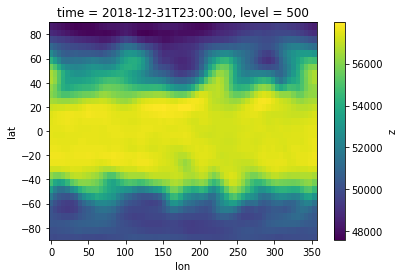

In [25]:
preds.z.sel(time='2018-12-31T23:00:00', level=500).plot()

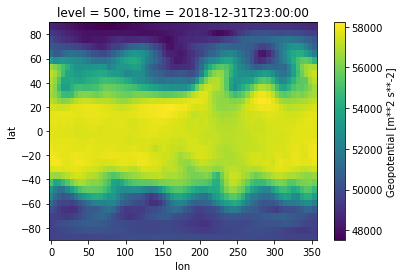

In [27]:
z500_valid.sel(time='2018-12-31T23:00:00').plot()

In [29]:
compute_weighted_rmse(preds.z.sel(level=500), z500_valid).load()

<xarray.DataArray 'z_rmse' ()>
array(426.35217427)
Coordinates:
    level    int64 500

In [30]:
compute_weighted_rmse(preds.t.sel(level=850), t850_valid).load()

<xarray.DataArray 't_rmse' ()>
array(2.41918565)
Coordinates:
    level    int64 850